台銀美金定存各天期利率

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta


def fetch_rates(date):
    url = f"https://rate.bot.com.tw/ir/index/{date}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # 找到美金的利率行
    rows = soup.find_all("tr")
    for row in rows:
        if "美金" in row.text:
            cells = row.find_all("td", class_="text-right")
            rates = [cell.text.strip() for cell in cells]
            return rates
    return []


# 設定日期範圍
end_date = datetime.now()
# 台銀最多提供4年資訊
start_date = end_date.replace(year=end_date.year - 4)

# 儲存每個月第一天的利率資訊
data = []
while start_date <= end_date:
    first_day_of_month = start_date.replace(day=1)
    rates = fetch_rates(first_day_of_month.strftime("%Y-%m-%d"))
    if rates:
        data.append([first_day_of_month.strftime("%Y-%m-%d")] + rates)
    start_date += timedelta(days=32)
    start_date = start_date.replace(day=1)

# 將數據轉換為 pandas DataFrame
# 動態生成列名
column_names = ["日期"] + ["活期", "7天", "14天", "21天", "1個月", "3個月", "6個月", "9個月", "1年"]
df = pd.DataFrame(data, columns=column_names)
print(df.head())

# 儲存為 Excel 文件
df.to_excel("data/台銀美金定存利率_V1.xlsx", index=False)

           日期    活期    7天   14天   21天   1個月   3個月   6個月   9個月    1年
0  2021-02-01  0.05  0.08  0.08  0.08   0.1  0.15   0.2  0.25  0.28
1  2021-04-01  0.05  0.08  0.08  0.08   0.1  0.15   0.2  0.25  0.28
2  2021-05-01  0.03  0.08  0.08  0.08   0.1  0.15   0.2  0.22  0.25
3  2021-06-01  0.03  0.08  0.08  0.08   0.1  0.15   0.2  0.22  0.25
4  2021-07-01  0.03  0.06  0.06  0.06  0.08  0.12  0.18   0.2  0.22


優化以上代碼

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

def fetch_rates(date):
    """
    從台灣銀行網站爬取指定日期的美金定存利率
    :param date: 日期 (格式：YYYY-MM-DD)
    :return: 各定存期間的利率列表 (若無數據則返回空列表)
    """
    url = f"https://rate.bot.com.tw/ir/index/{date}"
    
    # 添加 `User-Agent` 避免被封鎖
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    # 發送 HTTP GET 請求
    response = requests.get(url, headers=headers)

    # 確保請求成功
    if response.status_code != 200:
        print(f"⚠️ 無法取得 {date} 的數據 (HTTP {response.status_code})")
        return []

    # 解析 HTML 內容
    soup = BeautifulSoup(response.text, "html.parser")

    # 查找包含美金定存利率的表格行
    rows = soup.find_all("tr")
    for row in rows:
        if "美金" in row.text:
            cells = row.find_all("td", class_="text-right")
            rates = [cell.text.strip() for cell in cells]

            # 確保資料完整後轉換為浮點數
            try:
                rates = [float(rate.replace(",", "")) for rate in rates]
                return rates
            except ValueError:
                print(f"⚠️ {date} 數據格式異常: {rates}")
                return []
    
    print(f"⚠️ {date} 未找到美金定存利率數據")
    return []

# 設定抓取範圍 (最近 4 年)
end_date = datetime.now()
start_date = end_date.replace(year=end_date.year - 4)

# 儲存每個月第一天的利率資訊
data = []
while start_date <= end_date:
    # 取得當月第一天
    first_day_of_month = start_date.replace(day=1)
    rates = fetch_rates(first_day_of_month.strftime("%Y-%m-%d"))
    
    if rates:
        data.append([first_day_of_month.strftime("%Y-%m-%d")] + rates)
    else:
        print(f"❌ {first_day_of_month.strftime('%Y-%m-%d')} 沒有可用數據")
    
    # 前進一個月
    start_date += timedelta(days=32)
    start_date = start_date.replace(day=1)

# 將數據轉換為 pandas DataFrame
column_names = ["日期", "活期", "7天", "14天", "21天", "1個月", "3個月", "6個月", "9個月", "1年"]
df = pd.DataFrame(data, columns=column_names)

# 顯示前幾行數據
print(df.head())

# 儲存為 Excel 文件，檔名包含日期
current_date = datetime.now().strftime("%Y%m%d")
file_name = f"data/台銀美金定存利率_{current_date}.xlsx"
df.to_excel(file_name, index=False)
print(f"✅ 已儲存至 {file_name}")


           日期    活期    7天   14天   21天   1個月   3個月   6個月   9個月    1年
0  2021-02-01  0.05  0.08  0.08  0.08  0.10  0.15  0.20  0.25  0.28
1  2021-04-01  0.05  0.08  0.08  0.08  0.10  0.15  0.20  0.25  0.28
2  2021-05-01  0.03  0.08  0.08  0.08  0.10  0.15  0.20  0.22  0.25
3  2021-06-01  0.03  0.08  0.08  0.08  0.10  0.15  0.20  0.22  0.25
4  2021-07-01  0.03  0.06  0.06  0.06  0.08  0.12  0.18  0.20  0.22
✅ 已儲存至 data/台銀美金定存利率_20250228.xlsx


讀取前面儲存的文件進行繪圖

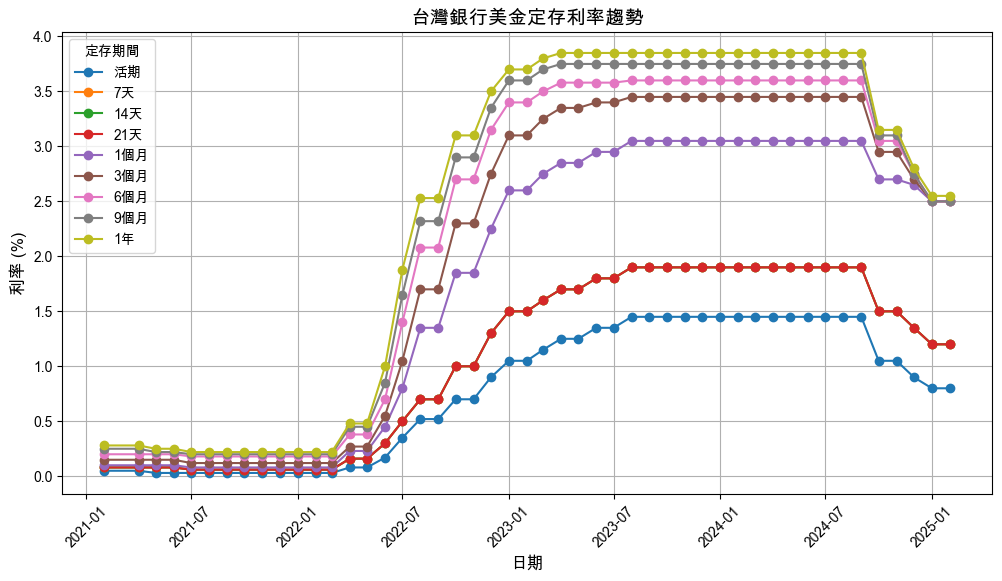

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 讀取 Excel 文件
file_path = "data/台銀美金定存利率_20250228.xlsx"
df = pd.read_excel(file_path)

# 確保日期欄位為時間格式
df["日期"] = pd.to_datetime(df["日期"])

# 設定 MacOS 的字型，避免中文顯示亂碼
plt.rcParams["font.family"] = "Arial Unicode MS"

# 繪製折線圖
plt.figure(figsize=(12, 6))
# 排除日期欄位，只繪製數據欄位
for col in df.columns[1:]:
    plt.plot(df["日期"], df[col], label=col, marker="o", linestyle="-")

# 圖表標題與標籤
plt.title("台灣銀行美金定存利率趨勢", fontsize=14)
plt.xlabel("日期", fontsize=12)
plt.ylabel("利率 (%)", fontsize=12)
# 避免 X 軸日期擠在一起
plt.xticks(rotation=45)
plt.legend(title="定存期間", fontsize=10)
plt.grid(True)

# 顯示圖表
plt.show()
